# REPRESENTATION OF ARABS IN IN CINEMA BEFORE AND AFTER 2001
Here, we present a pipeline of cleaning, filtering and first analysis of the CMU dataset. We at first, we analyse the character etnicity and yearly numbers for characters. Then, we select only characters from the western world and do a first study on the genres. The study is directed to the plot study, using characher recognition to prepare the NLP analysis.

# Cleaning data

In [92]:
# libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
import spacy
import ast
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [93]:
# folders of imported files
folder_std = r'./MovieSummaries'
folder_add = r'./Added_df'

In [94]:
# import data. We will use the movie.metadata.tsv file
col_names = ['wikiID','freeID','movie_name','release_date','revenue','runtime','languages','countries','genres']
movies = pd.read_csv(folder_std + "/movie.metadata.tsv",sep='\t',names=col_names)
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [95]:
# the column release date is set to be a datetime object. We have two different formats. we solve this using a mask
release_date = pd.to_datetime(movies['release_date'],errors='coerce')
mask = release_date.isna()
second_format = pd.to_datetime(movies['release_date'][mask],format='%Y',errors='coerce')
release_date[mask] = second_format
movies['release_date'] = release_date

In [96]:
# Convert the countries, genres and languages columns to a list of countries
movies['countries'] = movies['countries'].apply(lambda x: list(json.loads(x).values()))
movies['genres'] = movies['genres'].apply(lambda x: list(json.loads(x).values()))
movies['languages'] = movies['languages'].apply(lambda x: list(json.loads(x).values()))
movies.head()

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


This is the movies Dataframe we will use for the rest of the project.

# Movies per year

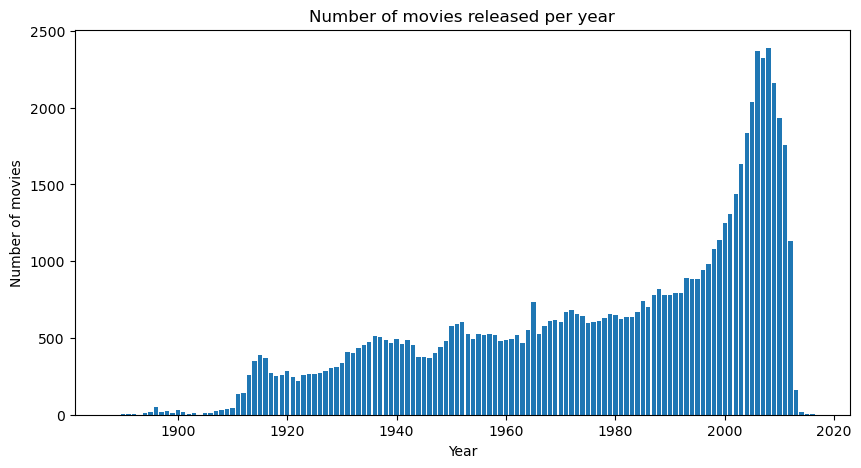

In [97]:
# we want to plot the number of movies released per year
# we group by year and count the number of movies
yearly_movies = movies.groupby(movies['release_date'].dt.year)['release_date'].count().reset_index(name='count')


# plot the number of movies per year
plt.figure(figsize=(10,5))
plt.bar(yearly_movies['release_date'],yearly_movies['count'])
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.show()

In [98]:
# we want to know how many movies were released before and after the year 2001, since this is the year of the twin towers attack
count_before2001 = yearly_movies[yearly_movies['release_date']<2001]['count'].sum()
count_after2001 = yearly_movies[yearly_movies['release_date']>=2001]['count'].sum()
print(f'Movies before the year 2001 are {count_before2001}')
print(f'Movies after the year 2001 are {count_after2001}')
print(f'The ratio of movies after the year 2001 is {count_after2001/(count_after2001+ count_before2001):.2}')  

Movies before the year 2001 are 49056
Movies after the year 2001 are 22488
The ratio of movies after the year 2001 is 0.31


The twin tower event has a relevant amount of films before (arounf 69%) and after (31%). This is a first sign that we can work analysing it through movies. 

Now, to really study arab actors, we read the actors df and work on the ethnicities.

# Ethnicity analysis

First of all, it is interesting to understand the ethnicity distribution of actors in the movies.

In [99]:
# Read the character.metadata.tsv file
col_names = ['wikiID','freeID','release_date','character_name','birth','gender','height','ethnicity_code', 'actor_name', 'age_at_release', 'freeID_character_actor_map', 'freeID_character', 'freeID_actor']
characters= pd.read_csv(open(folder_std + "/character.metadata.tsv",encoding='utf-8'), delimiter="\t", names=col_names)

characters.head()

,wikiID,freeID,release_date,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We merge movies and character dataframes by using the freeID and wikiID, (identifiers for movies) as keys.

In [100]:
# Merge the two dataframes on the wikiID and freeID
movies_characters = pd.merge(movies, characters, on=['freeID', 'wikiID'], how='inner', suffixes=('', '_y'))

# We drop the duplicate columns
movies_characters=movies_characters.drop(['release_date_y'], axis=1)
movies_characters.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [101]:
# print the number of Actor ethnicities (Freebase ID)
eth_num = movies_characters['ethnicity_code'].unique().shape[0]
print(f'There are {eth_num} different ethnicities')


There are 480 different ethnicities


How to decode the Freebase ID to a precise ethnicity? We used a query command to the freebase API and got a database to work on.

In [102]:
# read the csv file where we decode the ethnicities ID
ethnicity_decode = pd.read_csv(folder_add + "/ethnicity.csv",sep=',')
ethnicity_decode.columns= ['ethnicity_code', 'ethnicity_name']
ethnicity_decode.head()

,ethnicity_code,ethnicity_name
0,/m/07s8n27,Makonde people
1,/m/02k1vf,Powhatan
2,/m/0630vt,Apalachee people
3,/m/038cy,Germanic peoples
4,/m/03gq7tt,Hän people


In [103]:
# merging the two dataframes
movies_characters_eth= pd.merge(movies_characters, ethnicity_decode, how='left', left_on=['ethnicity_code'], right_on=['ethnicity_code'])
movies_characters_eth.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN


Did the ethnicity_decode work for all the freeID?

In [104]:
# filter the movies that have an eyhnicity_code but not the ethnicity_name
not_filtered= movies_characters_eth[movies_characters_eth['ethnicity_code'].notna() * movies_characters_eth['ethnicity_name'].isna()].copy()
print(f'characters not decoded: {not_filtered.shape[0]}')
print(f'portion of characters not decoded: {not_filtered.shape[0]/movies_characters_eth.shape[0]:.2}')

eth_not_decoded=not_filtered['ethnicity_code'].unique().shape[0]

eth_not_decoded_portion= eth_not_decoded/ movies_characters_eth['ethnicity_code'].unique().shape[0]
not_filtered['ethnicity_code'].unique().shape[0]

print(f'ethnicities not decoded {eth_not_decoded}')
print(f'portion of ethnicities not decoded {eth_not_decoded_portion:.2}')

characters not decoded: 50587
portion of characters not decoded: 0.11
ethnicities not decoded 158
portion of ethnicities not decoded 0.33


A good portion of ethnicity codes is not decoded into ethnicity names (33%). However, it is visible that these ethnicities appear rarely in the dataset, as only 11% of characters with ethnicity code do not present a correspondant ethnicity name.

We want to find the distribution of ethnicities in the dataset. 

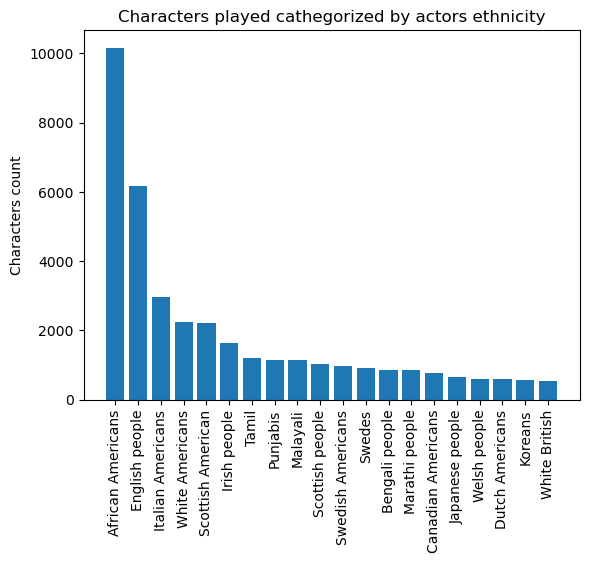

In [105]:
ethnicity_count = movies_characters_eth.groupby(movies_characters_eth['ethnicity_name'])['ethnicity_name'].count().reset_index(name = 'count')

ethnicity_count = ethnicity_count.sort_values(by='count',ascending=False)
plt.bar(ethnicity_count['ethnicity_name'].iloc[:20],ethnicity_count['count'].iloc[:20])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Characters played cathegorized by actors ethnicity')
plt.show()

In [106]:
print('In total, there are {} ethnicities of which we know the name.'.format(ethnicity_count['ethnicity_name'].shape[0]))

In total, there are 320 ethnicities of which we know the name.


To get the arabic ethnicities, we asked AI to identify ethnicities inside the list that can be considered of arabic culture. It is important to state that the arab ethnicities are really diverse and that generally anti-arab stereotypes are also linked to people of non-arab countries, but muslim. This is taken into consideration adding some ethnicities from Asia like Pakistan and Bengali.

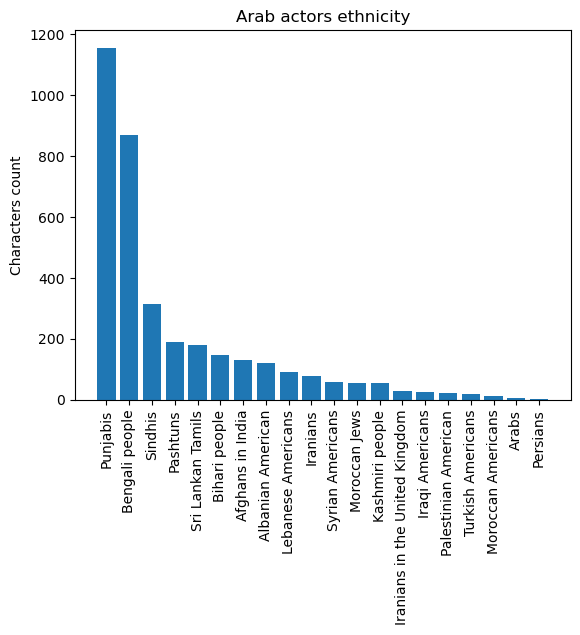

Arabic ethnicities are 20


In [107]:
# unique ethnicities
eth_unique=ethnicity_count['ethnicity_name'].unique()

# Commonly associated arab ethnicities. we used Chat GPT results
arab_ethnicities = ['Punjabis', 'Bengali people', 'Pashtuns', 'Sri Lankan Tamils', 'Bihari people', 'Sindhis', 'Kashmiri people', 'Afghans in India', 'Iranians', 'Albanian American', 'Syrian Americans', 'Moroccan Jews', 'Kurdish', 'Iraqi Americans', 'Turkish Americans', 'Lebanese Americans', 'Iranians in the United Kingdom', 'Palestinian American', 'Moroccan Americans', 'Egyptian Americans', 'Libyan Americans', 'Algerian Americans', 'Tunisian Americans', 'Yemeni Americans', 'Saudi Americans', 'Omani Americans', 'Emirati Americans', 'Qatari Americans', 'Kuwaiti Americans', 'Bahraini Americans', 'Jordanian Americans', 'Palestinians', 'Rohingya people', 'Malays', 'Indonesians', 'Bangladeshis', 'Pakistanis', 'Turks', 'Persians', 'Arabs']
# manually deleted: 'Gujarati peole'
# dubious about: 'Punjabis'

# Filter ethnicities corresponding to arab people
arab_ethnicities_subset = list(np.intersect1d(eth_unique, arab_ethnicities))

# Select only the ethnicity name of eth_unique in the arab_ethnicities_subset
arab_count = ethnicity_count[ethnicity_count['ethnicity_name'].isin(arab_ethnicities)]
arab_count=arab_count.sort_values(by='count', ascending=False)
plt.bar(arab_count['ethnicity_name'],arab_count['count'])
plt.xticks(rotation=90)
plt.ylabel('Characters count')
plt.title('Arab actors ethnicity')
plt.show()

# Number of Arabic ethnicities
print('Arabic ethnicities are {}'.format(len(arab_ethnicities_subset), arab_ethnicities_subset))

In [108]:
# proportion of arab characters
print(f"From the ethnicities provided, {arab_count['count'].sum()} characters over the years are classified as arab characters.")
print(f'Proportion of arab characters w.r.t. all characters is {arab_count["count"].sum()*100/ethnicity_count["count"].sum():.3}%')

From the ethnicities provided, 3551 characters over the years are classified as arab characters.
Proportion of arab characters w.r.t. all characters is 6.4%


# Arab names analysis

The main focus of our project is the character ethnicity, not the actor ethnicity, even though they are generally related. To do so, we analyse a list of commonly arab names and we check their presence in the character name column. 

By starting to filter the Dataframe for characters with a name within the list, we then filter for movies of United States and European production. Finally, we check if these character names are present in the plot, to asses the feasibility of the sentiment analysis, to be done in the following phases of the project.

A list of arab names (male and female) is retrieved from Wikipedia and is contained in the file arab_names.txt. This list is enriched by adding common AI generated adjectives which refer to the arab and muslim culture. This is done because the column characters_name uses a general description of the character when not a primary role. Also, some names where manually deleted as ambiguous and possibly having a different cultural origin.

In [109]:
# Read the file
with open(folder_add+'/arab_names.txt', 'r') as file:
    names = file.readlines()

# Clean and format the names (with list comprehension)
arab_names = [' '.join(name.strip().split(' ')[0:-1]) if '(name)' in name else ' '.join(name.strip().split(' ')[0:-2]) if '(given name)' in name else name.strip() for name in names]

arab_names = [str(item).lower() for item in arab_names]

In [110]:
# Function to determine if the character name is an arab name
def filter_arab_names(name):
    name = str(name).lower()
    for n in arab_names:
        if n in name.split():
            return True
        
    return False

The dataframe is filtered for what are designated as "arabic characters".

This line of code is the longest of the notebook to be executed.

In [111]:
movies_characters_ar = movies_characters_eth[movies_characters_eth['character_name'].apply(filter_arab_names)]
movies_characters_ar.head(2)

,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,birth,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name
202,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,[Hindi Language],[India],"[Family Film, Comedy]",Rahim,1923-11-11,M,NaN,/m/0dryh9k,Johnny Walker,60.0,/m/02vd0_r,/m/0h6_rbb,/m/07l4kn,NaN
564,4300418,/m/0bvx7h,The Hero: Love Story of a Spy,2003-04-11,NaN,182.0,[Hindi Language],[India],"[Thriller, Action Thrillers, Adventure, World ...",I.S.I Chief Ishak Khan,1932-06-22,M,NaN,/m/0dryh9k,Amrish Puri,70.0,/m/0k5bsd,/m/0h73qj8,/m/01k6nm,NaN


In [112]:
# Examples of character names classified as arab names
movies_characters_ar['character_name']

202                        Rahim
564       I.S.I Chief Ishak Khan
798                     Amal Raj
987                Ali La Pointe
991                       Halima
                   ...          
447804             Jamal Hassani
448077                     Nader
449075          Rev. Fred Sultan
449653                Bobby Nair
450406              Prince Akeem
Name: character_name, Length: 1501, dtype: object

In [113]:
print('The number of characters with a name classified as arab is {}.'.format(movies_characters_ar['character_name'].shape[0]))

The number of characters with a name classified as arab is 1501.


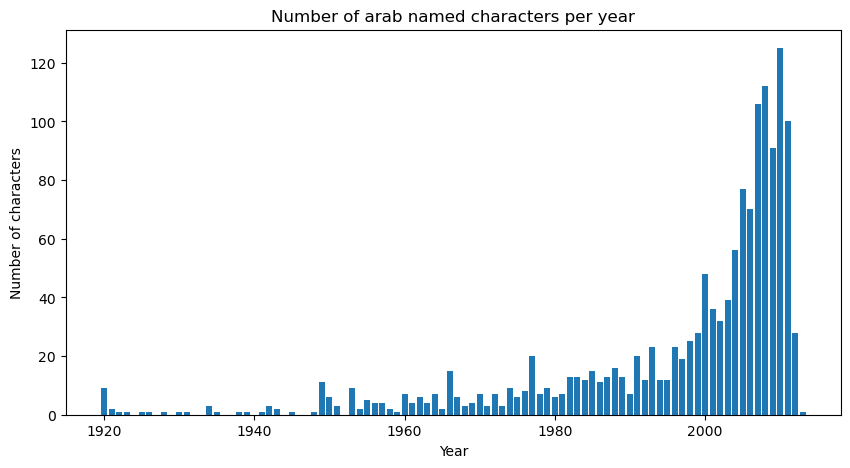

In [114]:
# How many movies with arab people per year
yearly_characters = movies_characters_ar.groupby(movies_characters_ar['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'])

plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year')
plt.show()

In [115]:
# classifying the movies as before and after 2001
count_before2001 = yearly_characters[yearly_characters['release_date']<=2001]['arabs_count'].sum()
count_after2001 = yearly_characters[yearly_characters['release_date']>2001]['arabs_count'].sum()
print(f'Arab named characters before the year 2001 are {count_before2001}')
print(f'Arab named characters after the year 2001 are {count_after2001}')
print('The total is less because some movies do not have the release date (NaN).')

Arab named characters before the year 2001 are 600
Arab named characters after the year 2001 are 837
The total is less because some movies do not have the release date (NaN).


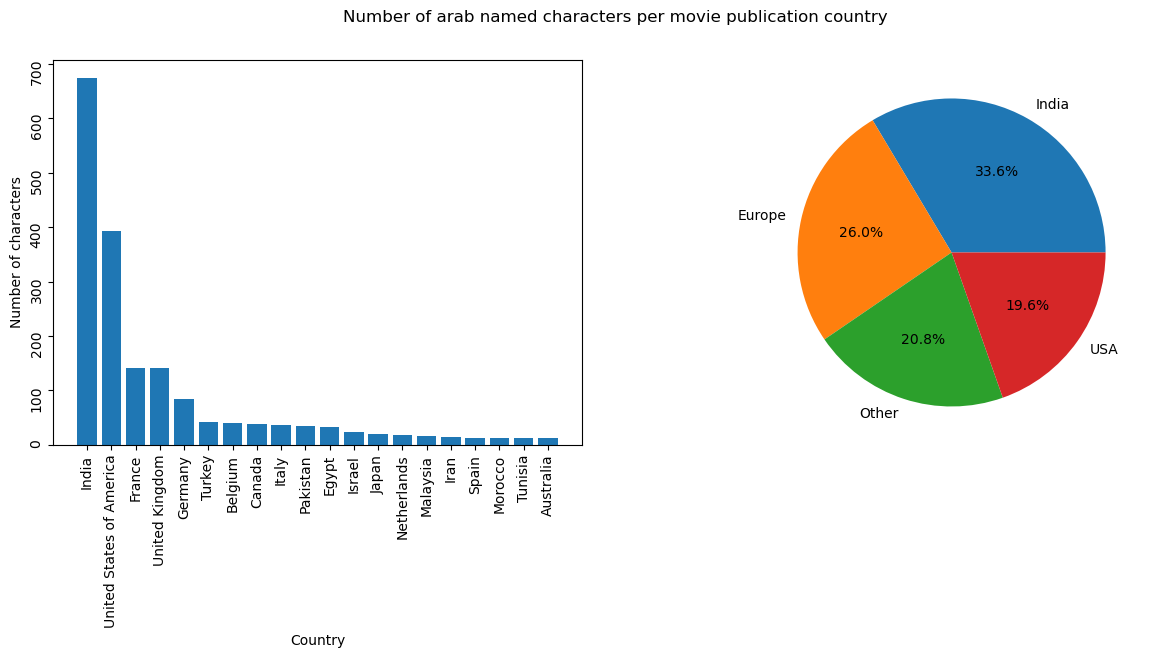

In [116]:
# Arab characters per country
exploded = movies_characters_ar.explode('countries')
country_counts = exploded['countries'].value_counts()

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(country_counts.index[:20],country_counts.values[:20])
ax[0].tick_params(labelrotation=90)
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Number of characters')
fig.suptitle('Number of arab named characters per movie publication country')

# Group USA, European countries all together, and classify the rest as 'other'
# European countries list
eu_countries = ['France','Germany','Italy','Spain','United Kingdom', 'Sweden', 'Netherlands', 'Denmark', 'Finland', 'Belgium', 'Greece', 'Austria', 'Switzerland', 'Norway', 'Ireland', 'Portugal', 'Luxembourg', 'Iceland', 'Czech Republic', 'Hungary', 'Poland', 'Romania', 'Bulgaria', 'Slovakia', 'Estonia', 'Latvia', 'Lithuania', 'Croatia', 'Slovenia', 'Cyprus', 'Malta']
exploded['countries'] = exploded['countries'].apply(lambda x: 'USA' if x=='United States of America' else 'Europe' if x in eu_countries else 'India' if x=='India' else 'Other')
country_grouped_counts = exploded['countries'].value_counts()

ax[1].pie(country_grouped_counts.values,labels=country_grouped_counts.index,autopct='%1.1f%%')
plt.show()


It is visible from the histogram above how the majority of arab characters are present in Indian movies. This is because arab/muslim culture is very influent in this country, for the vicinity to Arab countries.  

European countries can be considered under the United States cultural influence. Thus, it makes sense to add them into the analysis, to extend the number of characters and have a more statistically relevant sentiment analysis.

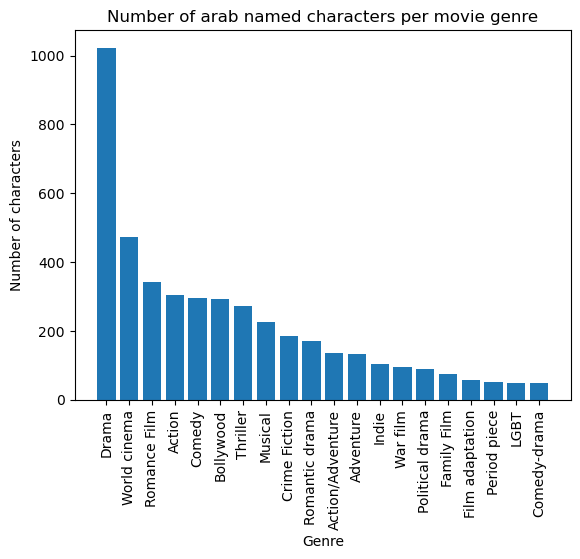

In [117]:
# Arab characters per genre
exploded = movies_characters_ar.explode('genres')
genre_counts = exploded['genres'].value_counts()
genre_counts = genre_counts.sort_values(ascending=False)
plt.bar(genre_counts.index[:20],genre_counts.values[:20])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per movie genre')
plt.show()

It is important to note that the graphs counts, both for country and genre cathegorizations, do not add up to the total number of arab characters in the Dataframe but to a larger number. This happens because some charecters are counted multiple times, as the movie they are in is classified with more than one genre or is published in more than one country. However, for our analysis it is important to have a number for the totality of each cathegories, making this graph meaningful as initial considerations before the actual project. 

As already stated, we are mainly interested in movies from USA, Canada and Europe.

In [118]:
# Filter arab movie characters from the western countries
western_countries = ['United States of America','Canada']+eu_countries
mask_characters_ar_western = movies_characters_ar['countries'].apply(lambda x: True if list(set(x) & set(western_countries)) != [] else False)
movies_characters_ar_western = movies_characters_ar[mask_characters_ar_western]
print('The total number of characters from western countries is {}.'.format(movies_characters_ar_western.shape[0]))

The total number of characters from western countries is 678.


In [119]:
# Arab movie characters from western countries count before and after 2001
yearly_characters_western = movies_characters_ar_western.groupby(movies_characters_ar_western['release_date'].dt.year)['character_name'].count().reset_index(name='arabs_count')
arab_western_before = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year<=2001].shape[0]
arab_western_after = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year>2001].shape[0]
print('The total number of characters from western countries before 2001 is {}.'.format(arab_western_before))
print('The total number of characters from western countries after 2001 is {}.'.format(arab_western_after))

The total number of characters from western countries before 2001 is 255.
The total number of characters from western countries after 2001 is 396.


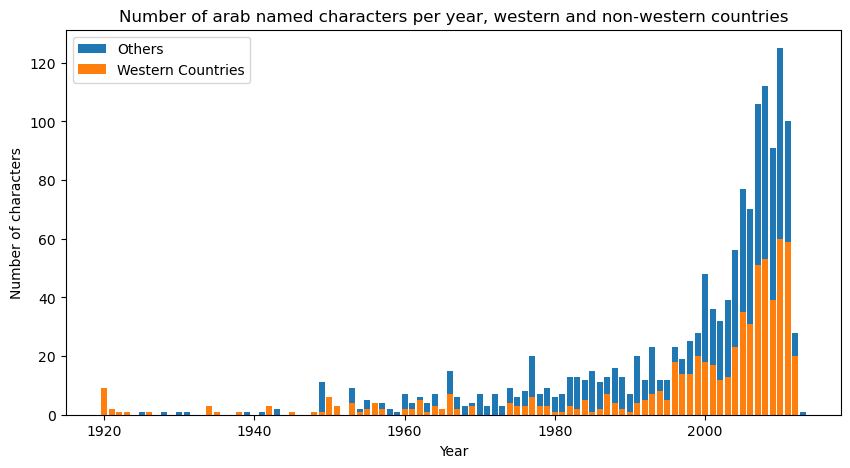

In [120]:
# Classify movies per year divided into western and non-western countries
plt.figure(figsize=(10,5))
plt.bar(yearly_characters['release_date'],yearly_characters['arabs_count'],label='Others')
plt.bar(yearly_characters_western['release_date'],yearly_characters_western['arabs_count'],label='Western Countries')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Number of arab named characters per year, western and non-western countries')
plt.show()

## First study on the arab characters role.

Now, we want to get a first sight on the arab presence in the filmography, and we are going to use the genre which they play, to get an idea if the use to play roles linked to crime, and violence. First of all, the analysis divides western world and other countries, to understand if in the first subset arab character play more the roles described before.

We select the genres that as a characteristic 'crime and violence' the following: Crime, War films.

In [121]:
# For every arab character, we indicate if they play a movie of the Crime, War Genre or not
Selected_genres = ['Crime Fiction', 'War film' ]  
movies_characters_ar_western.loc[:, 'cri_and_vio_genres'] = movies_characters_ar_western['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).values
movies_characters_ar_western.head(2)

C:\Users\ciril\AppData\Local\Temp\ipykernel_33996\2870513257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_characters_ar_western.loc[:, 'cri_and_vio_genres'] = movies_characters_ar_western['genres'].apply(lambda x: list(set(x) & set(Selected_genres)) != []).values


,wikiID,freeID,movie_name,release_date,revenue,runtime,languages,countries,genres,character_name,...,gender,height,ethnicity_code,actor_name,age_at_release,freeID_character_actor_map,freeID_character,freeID_actor,ethnicity_name,cri_and_vio_genres
987,9944484,/m/04dld6,The Battle of Algiers,1966-09-03,NaN,121.0,"[French Language, Arabic Language, Italian Lan...","[Italy, Algeria]","[Crime Fiction, World cinema, Drama, War film,...",Ali La Pointe,...,M,NaN,NaN,Brahim Haggiag,NaN,/m/0k4db3,/m/0n1r4ft,/m/0k4d9h,NaN,True
991,9944484,/m/04dld6,The Battle of Algiers,1966-09-03,NaN,121.0,"[French Language, Arabic Language, Italian Lan...","[Italy, Algeria]","[Crime Fiction, World cinema, Drama, War film,...",Halima,...,F,NaN,NaN,Fusia El Kader,NaN,/m/0gc3wv7,/m/0n1rn10,/m/0gb_xsd,NaN,True


Is it more frequent that arab actors have these type of movies (action and violence) in western cinema after 2001? We perform a t-test of the two distributions.

In [122]:
# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001
cri_and_vio_we_b2001 = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year<=2001]['cri_and_vio_genres']
cri_and_vio_we_a2001 = movies_characters_ar_western[movies_characters_ar_western['release_date'].dt.year>2001]['cri_and_vio_genres']

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(cri_and_vio_we_b2001.mean(), 3), round(cri_and_vio_we_b2001.std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(cri_and_vio_we_a2001.mean(), 3), round(cri_and_vio_we_a2001.std(), 3)))


The mean before 2001 is 0.231 with a standard deviation of 0.423.
The mean after 2001 is 0.283 with a standard deviation of 0.451.


In [123]:
# Perform a t-test to see if the proportion of arab characters playing in action and violent movies is different before and after 2001

stats.ttest_ind(cri_and_vio_we_b2001, cri_and_vio_we_a2001)

TtestResult(statistic=-1.4563428054974716, pvalue=0.14578147230364077, df=649.0)

The mean partecipation of arab characters in these types of films increases after 2001, from 23,1% to 28,3%. Still, we cannot state that one sample has a smaller mean than the other fot the t-test result. In fact, choosing a significance level $\alpha = 5\%$, 

$P_{value}$ > $\alpha$

And therefore we cannot reject the $H_0$, "the 2 independent samples have identical average".

Does this list change if we take only characters from USA movies? This country was directly hit by 2001.

In [124]:
# Filter arab movie characters from the USA
movies_characters_ar_USA=movies_characters_ar_western[ movies_characters_ar_western['countries'].apply(lambda x: list(set(x) & set(['United States of America'])) != []) ]

# Print mean values and standard deviations of arab characters partecipation in action and violent western movies before and after 2001
cri_and_vio_USA_b2001 = movies_characters_ar_USA[movies_characters_ar_USA['release_date'].dt.year<=2001]['cri_and_vio_genres']
cri_and_vio_USA_a2001 = movies_characters_ar_USA[movies_characters_ar_USA['release_date'].dt.year>2001]['cri_and_vio_genres']

print('The mean before 2001 is {} with a standard deviation of {}.'.format(round(cri_and_vio_USA_b2001.mean(), 3), round(cri_and_vio_USA_b2001.std(), 3)))
print('The mean after 2001 is {} with a standard deviation of {}.'.format(round(cri_and_vio_USA_a2001.mean(), 3), round(cri_and_vio_USA_a2001.std(), 3)))

# Perform a t-test to see if the proportion of arab characters playing in action and violent movies is different before and after 2001
stats.ttest_ind(cri_and_vio_USA_b2001, cri_and_vio_USA_a2001)

The mean before 2001 is 0.207 with a standard deviation of 0.406.
The mean after 2001 is 0.235 with a standard deviation of 0.425.


TtestResult(statistic=-0.6510021275184412, pvalue=0.5154470259456527, df=372.0)

We notive that the mean value is higher like in the hole western countries subset. The p-vaòue in this case is higher meaning we cannot reject the null hypothesis. This is due also to the smaller sample filtering for the US pubblished movies only.

In general, we would need to consider a proper observational study, using propensity scores to avoid possible confounders. For example there could be more male arab actors after 2001, that are more inclined have roles in these genres. We will advance using this approch for P3

# Adding IMDb ratings and relevancy measure
We import the IMDb dataset to populate the our data with user ratings

In [125]:
# IMPORTING IMDb DATASET
imdb_data_ratings = pd.read_csv(folder_std + "/imdb_ratings.tsv",sep='\t')
imdb_data_titles = pd.read_csv(folder_std + "/imdb_titles.tsv",sep='\t',low_memory=False)
imdb_data = pd.merge(imdb_data_ratings,imdb_data_titles,on=['tconst'])

imdb_data = imdb_data.rename(columns={'primaryTitle': 'movie_name'})

imdb_data = imdb_data[['movie_name','averageRating']]
# imdb_data.head()

In [126]:
# removing duplicate movie entries 
# by compressing them into 1 entry which is the mean
imdb_data_mean = imdb_data.groupby(['movie_name']).mean().reset_index().drop_duplicates()

In [127]:
# making all titles lower-case to make merging more effective
imdb_data_mean['movie_name'] = imdb_data_mean['movie_name'].str.lower()
movies_characters_ar.iloc[:,2] = movies_characters_ar['movie_name'].str.lower()

# merging
movies_characters_ar_ratings = pd.merge(movies_characters_ar,imdb_data_mean,on=['movie_name'],how='left')

In [128]:
import warnings
warnings.filterwarnings("ignore")
# removing rows with NaN revenue data
filtered_movies_characters_ar_ratings = movies_characters_ar_ratings[movies_characters_ar_ratings['revenue'].notna() & movies_characters_ar_ratings['averageRating'].notna()]
filtered_movies_characters_ar_ratings.shape
# creating a year column
filtered_movies_characters_ar_ratings['release_year'] = filtered_movies_characters_ar_ratings['release_date'].dt.year

We compute the following indicator for each movie as a weighted sum of rating and revenue data: 
$$\textrm{coeff} = C1\cdot \overline{\textrm{revenue}} + C2\cdot \overline{\textrm{rating}}$$

Where the $\overline{\textrm{bar}}$ means the value is normalized with the movie's release year's mean and standard deviation.

In [129]:
# Calculate the new column "relevance_coeff" (standardization by year)

weighting = [0.5, 0.5] # equal weights
filtered_movies_characters_ar_ratings['relevance_coeff'] = weighting[0] * ((filtered_movies_characters_ar_ratings['revenue'] - filtered_movies_characters_ar_ratings.groupby('release_year')['revenue'].transform('mean')) 
/ filtered_movies_characters_ar_ratings.groupby('release_year')['revenue'].transform('std')) + \
                        weighting[1]  * ((filtered_movies_characters_ar_ratings['averageRating'] - filtered_movies_characters_ar_ratings.groupby('release_year')['averageRating'].transform('mean')) 
                                         / filtered_movies_characters_ar_ratings.groupby('release_year')['averageRating'].transform('std'))

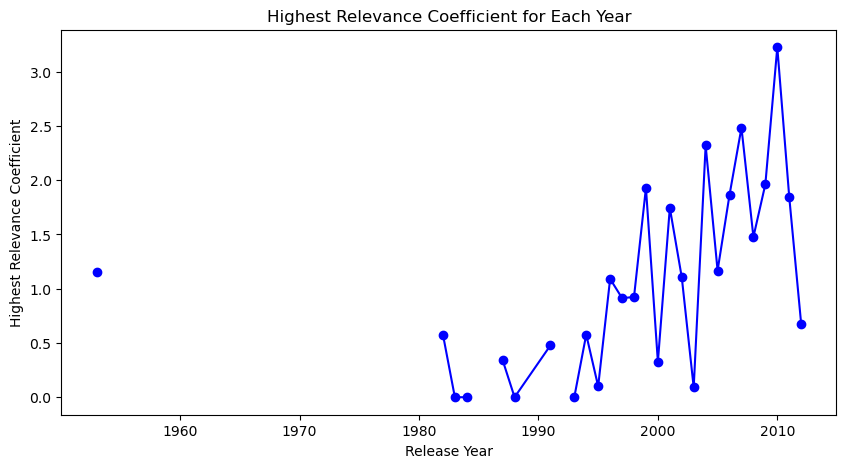

In [130]:
plt.figure(figsize=(10,5))
max_relevance_per_year_ar = filtered_movies_characters_ar_ratings.groupby('release_year')['relevance_coeff'].max()

# Plot the results
plt.plot(max_relevance_per_year_ar.index, max_relevance_per_year_ar.values, marker='o', linestyle='-', color='b')
plt.xlabel('Release Year')
plt.ylabel('Highest Relevance Coefficient')
plt.title('Highest Relevance Coefficient for Each Year')
plt.show()

# Plot text analysis through NLP

It is important to verify that the characters we are considering are present in the plot. In fact, only these characters can be used for a sentiment analysis in the further stages of the project.

We want to import the plot summaries and add them to the current Dataframe, containing arab characters.

In [4]:
# import the plot summaries
plot_summaries = pd.read_csv(folder_std + "/plot_summaries.txt",sep='\t',names=['wikiID','summary'])
plot_summaries.head()

,wikiID,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [5]:
# checking for NaN values
plot_summaries.isna().sum()

wikiID     0
summary    0
dtype: int64

In [6]:
#checking the length distribution for the movie plots
plot_summaries['length_plot'] = plot_summaries['summary'].apply(lambda x: len(x))
plot_summaries

,wikiID,summary,length_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178
1,31186339,The nation of Panem consists of a wealthy Capi...,4559
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",220
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",2971
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,871
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289


In [7]:
plot_summaries['length_plot'].describe()

count    42303.000000
mean      1784.034229
std       1808.925536
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: length_plot, dtype: float64

We can see from the describe function that the distribution of movie plots is very spread as the mean as big as the standard deviation. In addition, we have a movie plot with 28159 characters which may suggest that there are outliers, since the upper quartile is much smaller than the maximum. We decide to look at it more closely using a box plot.

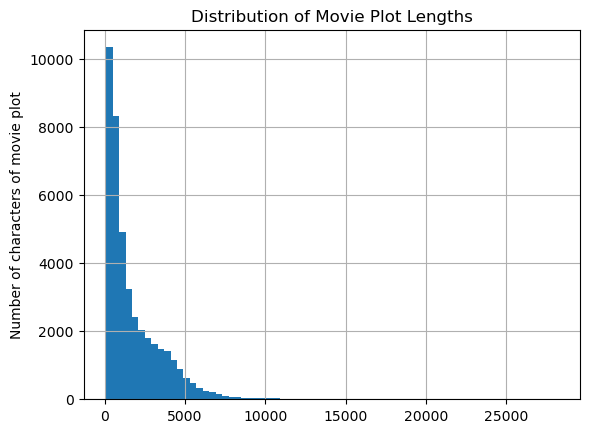

In [8]:
plot_summaries.hist(column=['length_plot'],bins=70)
# Add titles to the plot and axes
plt.title('Distribution of Movie Plot Lengths')
plt.ylabel('Number of characters of movie plot')
# Show the plot
plt.show()

Our intuition was right. We can see from the histogram that the distribution of length of the movie plots is heavy tailed. Consequently, we decide to show the distribution with a boxplot employing a logarithmic scale for the y-axis, to make the visualization more interpretable.

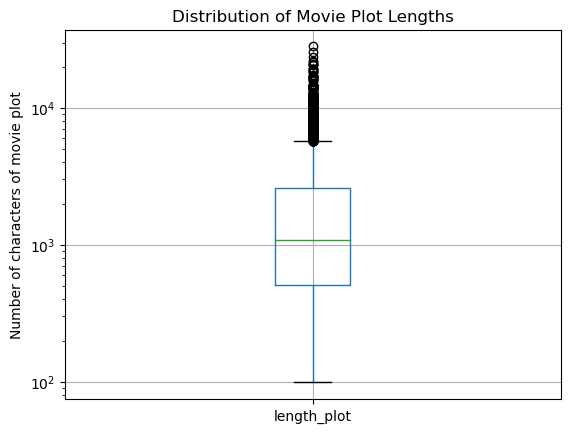

In [9]:
plot_summaries.boxplot(column=['length_plot'])
plt.yscale('log')
# Add titles to the plot and axes
plt.title('Distribution of Movie Plot Lengths')
plt.ylabel('Number of characters of movie plot')

# Show the plot
plt.show()

## Named entity recognition

We need to a partial preprocessing of the summaries before feeding the text to the spacy model to perform named entity recognition. For example, for movie number 4075 in the movie plots dataset, the plot begins with "{{Further2}}", which maybe recognized as an entity. We only do a partial preprocessing to remove alpha numeric characters and some punctuation. We will not make the text to lower case since the model uses the cases information and the model processes the raw text and do some preprocessing internally (for example removal of stopwords).

In [10]:
def partial_preprocess_for_ner(text):
    words = text.split()
    punctuation=list(string.punctuation)
    p= [word for word in words if word.isalpha() and word not in punctuation]
    res = " ".join([word for word in p])
    return res

We employ the spaCy tool, utilizing the 'en_core_web_sm' model, to conduct a linguistic analysis of movie plots. spaCy, a language processing tool, possesses capabilities such as sentence breakdown, word tagging, and named entity recognition (NER). Specifically, we leverage its NER functionality to identify individuals in film summaries. Our interest lies in determining whether these individuals bear Arabic names. To achieve this, we cross-reference the identified names from spaCy with a dataset containing Arabic names.

In [11]:
# NER MODEL (takes 54m 46.9s)
'''model = spacy.load("en_core_web_sm") 
 
def extract_entities(text):
    doc = model(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

# Apply the function to the DataFrame and create a new column for named entities
plot_summaries['named_entities'] = plot_summaries['summary'].apply(partial_preprocess_for_ner)
plot_summaries['named_entities'] = plot_summaries['summary'].apply(extract_entities)
plot_summaries

# plot_summaries.to_csv("basic_preprocessed_ner.csv")'''

,wikiID,summary,length_plot,named_entities
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",220,"[(Reema, PERSON), (Muslim, NORP), (Malabar, GP..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",2971,"[(1928, DATE), (Hollywood, GPE), (Leo Andreyev..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,871,"[(American, NORP), (Randy Parsons, ORG), (mid-..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",1289,"[(Abdur Rehman Khan, PERSON), (Afghanistan, GP..."


In [198]:
# write plot summaries to a file csv
# plot_summaries.to_csv(folder_add + "/basic_preprocessed_ner.csv")

# read the file
plot_summaries_try = pd.read_csv(folder_add + "/basic_preprocessed_ner.csv").drop(['Unnamed: 0'], axis=1)
plot_summaries_try.head()

,wikiID,summary,length_plot,named_entities
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[('Lyosha', 'PERSON')]"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[('Panem', 'ORG'), ('Capitol', 'ORG'), ('twelv..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[('Poovalli Induchoodan', 'PERSON'), ('six yea..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[('New York City', 'GPE'), ('Florida', 'GPE'),..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[('Seventh-day', 'DATE'), ('Adventist Church',..."


In [12]:
# We make a deep copy of the dataframe, before filtering in subsequent cells
plot_summaries_chars = plot_summaries.copy()

In [13]:
# Remove brackets in named_entities column
plot_summaries_chars['named_entities']= plot_summaries_chars['named_entities'].apply(lambda x: ast.literal_eval(str(x)))

In [14]:
#we do a set so that we only count each entity one time.
plot_summaries_chars["Chars in plot"] = plot_summaries_chars['named_entities'].apply(lambda x: 
   set( [ entity for entity in x if entity[1] == "PERSON"])
)
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}"
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Thresh, PERSON), (Crane, PERSON), (Peeta Mel..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Mooppil Nair, PERSON), (Poovalli Induchoodan..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Henry, PERSON), (Santa Claus, PERSON), (Char..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Gossip, PERSON), (Azaria, PERSON), (Lindy, P..."


In [15]:
all_chars = [char for sublist in plot_summaries_chars['Chars in plot'] for char in sublist]
chars_counts = Counter(all_chars)
chars_counts.most_common(10)

[(('Jack', 'PERSON'), 608),
 (('John', 'PERSON'), 583),
 (('Tom', 'PERSON'), 571),
 (('Sam', 'PERSON'), 494),
 (('Mary', 'PERSON'), 482),
 (('Joe', 'PERSON'), 479),
 (('David', 'PERSON'), 462),
 (('Paul', 'PERSON'), 440),
 (('Michael', 'PERSON'), 420),
 (('Peter', 'PERSON'), 407)]

In [16]:
# Take only character names
char_names = [x[0] for x in all_chars]

In [24]:
#get the top 10 arabic names mentionned in the movie plots
res = []
for element,count in chars_counts.items():
    name = str(element[0]).lower()
    if(name in arab_names):
        res.append((name,count))
    
res = sorted(res, key=lambda pair: pair[1], reverse=True)
res[:10]

[('ali', 109),
 ('omar', 33),
 ('hassan', 28),
 ('malik', 28),
 ('salim', 27),
 ('abbas', 24),
 ('fatima', 23),
 ('rahman', 22),
 ('aman', 22),
 ('samir', 20)]

In [25]:
# Add a column to the dataframe that indicates if the movie plot contains an arabic name
plot_summaries_chars['has_arabic_character'] = plot_summaries_chars['Chars in plot'].apply(lambda x: any(str(entity[0]).lower() in arab_names for entity in x))

# New dataframe, filtering on movies with arabic characters
movies_with_arabic = plot_summaries_chars[plot_summaries_chars['has_arabic_character']==True]
display(movies_with_arabic.head())
print(f'There are {movies_with_arabic.shape[0]} movies with arabic characters')

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Karen Hansen, PERSON), (Ari, PERSON), (Gan D...",True
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Rick, PERSON), (Pee Wee, PERSON), (Kid, PERS...",True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Anna Khitrova, PERSON), (Helen, PERSON), (Ni...",True
46,19174305,"Tahaan lives with his grandfather , mother Ha...",2091,"[(Tahaan, GPE), (Haba, ORG), (Zoya, PERSON), (...","{(Tahaan, PERSON), (Subhan, PERSON), (Zafar, P...",True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Jamal, PERSON), (Ray Jackson, PERSON), (Moni...",True


There are 892 movies with arabic characters


### Pre-processing pipeline for wordcloud

We want to visualize the most recurrent words that appear in teh movie plots that mention an arabic character and compare it with the same visualization for movies that do not mention arabic characters. 

To do so, we need to pre-process plot summaries so that we can evaluate the most meaningful words in each plot. First, we remove punctuation and english stopwords (provided by nltk library). Secondly, we lemmatize. We chose lemmatization over stemming because it is more accurate and our dataset is not large, making the computational time acceptable.

In [98]:
wl=WordNetLemmatizer()
stop=set(stopwords.words('english'))
punctuation=list(string.punctuation)

stop.update(punctuation)



def preprocess_text(text):
    text = text.lower()
    words = text.split()
    p= [word for word in words if word.isalpha() and word not in stop]
    text= " ".join([wl.lemmatize(word) for word in p])
    
    
    return text

In [99]:
# Apply the preprocessing function to the summaries
movies_with_arabic.loc[:,1]= movies_with_arabic['summary'].apply(lambda x:preprocess_text(x))

movies_with_arabic.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,1
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Karen Hansen, PERSON), (Mohammad Amin al-Hus...",True,film based event happened ship exodus well eve...
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Lee, PERSON), (Shelia Kid's, PERSON), (Zora,...",True,following sudden death father local church don...
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Anna, PERSON), (Nikolai Luzhin, PERSON), (Ch...",True,anna khitrova midwife london find diary body g...
46,19174305,"Tahaan lives with his grandfather , mother Ha...",2091,"[(Tahaan, GPE), (Haba, ORG), (Zoya, PERSON), (...","{(Tahaan, PERSON), (Subhan, PERSON), (Zoya, PE...",True,tahaan life grandfather mother haba older sist...
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Baby Boy, PERSON), (Michael/Killjoy, PERSON)...",True,film begin boy named michael kid hots beautifu...


In [100]:
# Helper function to plot wordclouds
def make_WC_visualization(data,mask=None):
    text =  " ".join(data) 
    wc = WordCloud(background_color='white',colormap='copper',max_words=100,mask=mask, width = 800, height = 500).generate(text)
    plt.imshow(wc)
    plt.axis("off")

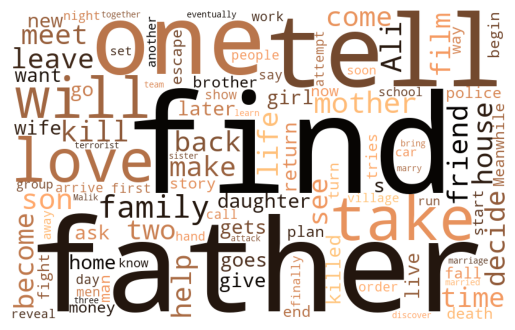

In [101]:
# Wordcloud visualization of the 100 most common words in the movie plots
make_WC_visualization(movies_with_arabic['summary'])

Now we want to show the wordcloud for movies without arab characters in the plot.

In [102]:
movies_with_nonarabs = plot_summaries_chars[plot_summaries_chars['has_arabic_character']==False]
movies_with_nonarabs.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Snow, PERSON), (Rue, PERSON), (Cato, PERSON)...",False
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Nandagopal Maarar, PERSON), (Anuradha, PERSO...",False
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Nellie, PERSON), (Mor...",False
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Azaria, PERSON), (Gossip, PERSON), (Michael,...",False


In [103]:
movies_with_nonarabs['summary'] = movies_with_nonarabs['summary'].apply(lambda x:preprocess_text(x))
movies_with_nonarabs.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
0,23890098,taxi driver develop bizarre despite realize di...,178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False
1,31186339,nation panem consists wealthy capitol twelve p...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Snow, PERSON), (Rue, PERSON), (Cato, PERSON)...",False
2,20663735,poovalli induchoodan sentenced six year prison...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Nandagopal Maarar, PERSON), (Anuradha, PERSO...",False
3,2231378,lemon drop kid new york city illegally touting...,4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Nellie, PERSON), (Mor...",False
4,595909,adventist church pastor michael wife two daugh...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Azaria, PERSON), (Gossip, PERSON), (Michael,...",False


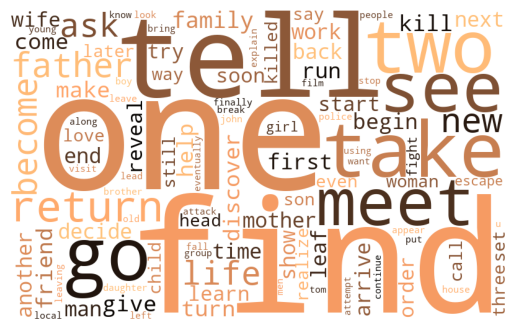

In [104]:
make_WC_visualization(movies_with_nonarabs['summary'])

We can see clearly from the wordcloud visualization that the lexical field differ: for the movies with arabic have much more words with bad conotation, like kill, drugs, help, and attack whereas for the movies in which the plot doesn't mention an arabic character, the most repeated words are more neutral and/or more positive for example family, life, son ,decide... Eventhough both negative words and positive words in both categories, it is worth noting that the scales for the words in common differ: for example the word kill, we can see that it is bigger in the movies with arabic characters. Eventhough, the number of films of each categories vary a lot since we don't have much arabic characters mentioned in the plot(897 vs 41406), it is worth extending our research to also check for arabic locations and also check for movies where arabic characters plays a secondary role and is not mentioned in the plot.

In [105]:
# Add the country feature to the plot_summaries_chars dataframe
plot_summaries_chars = pd.merge(plot_summaries_chars, movies[['wikiID','countries','release_date']], left_on='wikiID',right_on='wikiID', how='left')
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False,"[France, Soviet Union, Russia]",1990-09-07
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Snow, PERSON), (Rue, PERSON), (Cato, PERSON)...",False,[United States of America],2012-03-12
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Nandagopal Maarar, PERSON), (Anuradha, PERSO...",False,[India],2000-01-01
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Nellie, PERSON), (Mor...",False,[United States of America],1951-03-08
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Azaria, PERSON), (Gossip, PERSON), (Michael,...",False,"[United States of America, Australia, New Zeal...",1988-11-03


In [106]:
plot_summaries_chars.dropna(inplace=True, subset=['countries'])
plot_summaries_chars['is_western_country'] = plot_summaries_chars['countries'].apply(lambda x: not set(x).isdisjoint(set(western_countries)))
plot_summaries_chars.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",178,"[(Lyosha, PERSON)]","{(Lyosha, PERSON)}",False,"[France, Soviet Union, Russia]",1990-09-07,True
1,31186339,The nation of Panem consists of a wealthy Capi...,4559,"[(Panem, ORG), (Capitol, ORG), (twelve, CARDIN...","{(Snow, PERSON), (Rue, PERSON), (Cato, PERSON)...",False,[United States of America],2012-03-12,True
2,20663735,Poovalli Induchoodan is sentenced for six yea...,3099,"[(Poovalli Induchoodan, PERSON), (six years, D...","{(Nandagopal Maarar, PERSON), (Anuradha, PERSO...",False,[India],2000-01-01,False
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",4917,"[(New York City, GPE), (Florida, GPE), (Moose ...","{(Santa Claus, PERSON), (Nellie, PERSON), (Mor...",False,[United States of America],1951-03-08,True
4,595909,Seventh-day Adventist Church pastor Michael Ch...,2425,"[(Seventh-day, DATE), (Adventist Church, ORG),...","{(Azaria, PERSON), (Gossip, PERSON), (Michael,...",False,"[United States of America, Australia, New Zeal...",1988-11-03,True


In [107]:
# movies with arabic characters from western countries
movies_ar_western = plot_summaries_chars[(plot_summaries_chars['has_arabic_character']) & (plot_summaries_chars['is_western_country'])]

movies_ar_western.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character,countries,release_date,is_western_country
13,1335380,The film is based on the events that happened ...,4385,"[(Exodus, PRODUCT), (1947, DATE), (Israel, GPE...","{(Karen Hansen, PERSON), (Mohammad Amin al-Hus...",True,[United States of America],1960-12-15,True
14,1480747,{{plot}} Following the sudden death of Kid's f...,6993,"[(Foreplay, WORK_OF_ART), (Shelia Landreaux, P...","{(Lee, PERSON), (Shelia Kid's, PERSON), (Zora,...",True,[United States of America],1991-10-23,True
42,5425205,"Anna Khitrova , a British-Russian midwife at a...",3094,"[(Anna Khitrova, PERSON), (British-Russian, NO...","{(Anna, PERSON), (Nikolai Luzhin, PERSON), (Ch...",True,"[United States of America, Canada, United King...",2007-09-08,True
59,15161056,{{plot}} The film begins with a boy named Mich...,4992,"[(Michael, PERSON), (Jada, PERSON), (Jada, GPE...","{(Baby Boy, PERSON), (Michael/Killjoy, PERSON)...",True,[United States of America],2000-01-01,True
84,1282593,It is spring. Randy Dean is a high school seni...,3620,"[(Randy Dean, PERSON), (only one, CARDINAL), (...","{(Frank, PERSON), (Evelyn, PERSON), (Randy Dea...",True,[United States of America],1995-01-01,True


In [108]:
# Movies from western countries
movies_western = plot_summaries_chars[plot_summaries_chars['is_western_country']]
char_percent = movies_ar_western['has_arabic_character'].sum()/movies_western.shape[0]
print(f'Percentage of characters in the summary: {char_percent:.3}')
print(f'Number of characters in the summary: {movies_ar_western["has_arabic_character"].sum()}')
print(f'Number of characters not in the summary: {movies_western.shape[0]-movies_ar_western["has_arabic_character"].sum()}')

Percentage of characters in the summary: 0.0123
Number of characters in the summary: 352
Number of characters not in the summary: 28301


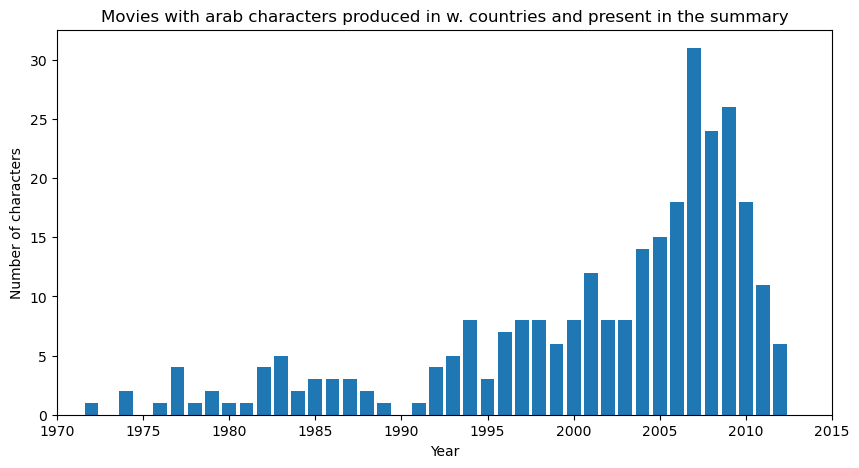

Movies with arab characters present in the summary before 2001: 156
Movies with arab characters present in the summary after 2001: 179


In [109]:
# Plot the yearly number of arab characters in movies published in USA, present in the summary


plt.figure(figsize=(10,5))
yearly_ar_we_movies = movies_ar_western.groupby(movies_ar_western['release_date'].dt.year)['has_arabic_character'].sum().reset_index(name='characters_ar_we_inplot')
plt.bar(yearly_ar_we_movies['release_date'],yearly_ar_we_movies['characters_ar_we_inplot'])
plt.xlim(1970,2015)
plt.xlabel('Year')
plt.ylabel('Number of characters')
plt.title('Movies with arab characters produced in w. countries and present in the summary')
plt.show()

print(f'Movies with arab characters present in the summary before 2001: {yearly_ar_we_movies[yearly_ar_we_movies["release_date"]<=2001]["characters_ar_we_inplot"].sum()}')
print(f'Movies with arab characters present in the summary after 2001: {yearly_ar_we_movies[yearly_ar_we_movies["release_date"]>2001]["characters_ar_we_inplot"].sum()}')

# Milestone 3

## Assessing accuracy of arab names identification

Arab names list has been slightly changed from the one provided in milestone 2. In particular, the task of eliminating names which are likely to be present in other cultures from the wikepedia list of arabic names is now assigned to a large language model (i.e. chatGPT) instead of being done manually. This approach provides better accuracy of the filtered list and, subsequently, of the identification of arab characters in movie plots. In general, the approach consists in identifying names that most probably correspond to arab characters eliminating ambiguous ones, to prioritize the accuracy of the selection to the number of characters. The resulting list does not change significantly.

In [170]:
# Read the file
with open(folder_add+'/arab_names.txt', 'r') as file:
    names = file.readlines()

# Clean and format the names (with list comprehension)
arab_names = [' '.join(name.strip().split(' ')[0:-1]) if '(name)' in name else ' '.join(name.strip().split(' ')[0:-2]) if '(given name)' in name else name.strip() for name in names]

arab_names = [str(item).lower() for item in arab_names]

# Read the csv file generated by chatGPT interface, with arab names common in other cultures
common_names_df = pd.read_csv(folder_add+'/common_names.csv', header=None)

# Convert DataFrame to a list of lowercase names
common_names = common_names_df[0].str.lower().tolist()

# Filter arab names from common names
arab_names = [name for name in arab_names if name not in common_names]
arab_names[:10]

['abbad',
 'abbas',
 'abd al-uzza',
 'abdus salam',
 'abd manaf',
 'abd rabbo',
 'abdel fattah',
 'abdel nour',
 'abdi',
 'abdolreza']

Another important point to validate our analysis is understanding how well the arabic names recognition of our model works. To do so, our character names resulting from the Named entity recognition through `"en_core_web_sm"` spacy model and then intersected to the list `arabic_names`, are compared with the results of the large language model chatGPT. 50 randomly chosen plots containing at least one arab name are used to do this manual check.

In [193]:
movies_with_arabic_sample.iloc[1]['summary']

'This is a single handed war on terrorism. Commando in the Indian Army Bharath considers his nation as his mother. He does not want anyone to cut it like piece of cake. He is very strong and stubborn in his decision. Captain Bharath is Salim, Captain Bharath is Jai Hind. In his first assignment to trace or trash the terrorist operation he round off terrorist Masood and hand over to the government of India. He gets Shourya Chakra for it. In a short span of time Masood is freed on a hijack of an Indian Air plane with Rs.200 crores demand set by terrorist gang. Feeling ashamed of this, Captain Bharath in his second assignment takes his own decision. He seeks the support of his doctor wife Anjali  in declaring him as dead. As Salim and as Jai Hind, Captain Bharath now with a clue of terrorist attack in prominent places in Bangalore put an end to terrorist activities and surrenders to the government. For taking law in to his hand Captain Bharath is sentenced for life imprisonment. The publi

In [184]:
# Select 50 random movies containing at least one arab character
movies_with_arabic_sample = movies_with_arabic.sample(n=50, random_state=1)

# Series of lists of arab characters in the sample plots
output = movies_with_arabic_sample['Chars in plot'].apply(lambda x: [entity[0] for entity in x if entity[0].lower() in arab_names])
pd.reset_option('display.max_colwidth')
movies_with_arabic_sample.head()

,wikiID,summary,length_plot,named_entities,Chars in plot,has_arabic_character
18219,9890983,Indian cities are being terrorized by a group ...,4895,"[(Indian, NORP), (Abhay Singh, PERSON), (Abbas...","{(IGP Pathak, PERSON), (Lodhi, PERSON), (Shiv,...",True
10035,29982114,This is a single handed war on terrorism. Comm...,1052,"[(the Indian Army Bharath, ORG), (Bharath, PER...","{(Bharath, PERSON), (Salim, PERSON), (Jai Hind...",True
3240,2005119,Sabah is a 40-year-old single immigrant from S...,1791,"[(Sabah, PERSON), (40-year-old, DATE), (Syria,...","{(Sabah, PERSON), (Majid, PERSON)}",True
18513,13084794,High school French teacher Sabine reads to her...,1384,"[(French, NORP), (Sabine, ORG), (French, NORP)...","{(Simon, PERSON), (Sami, PERSON), (Tom, PERSON...",True
15563,1055569,England manager Phil Cope suffers a heart atta...,3675,"[(England, GPE), (Phil Cope, PERSON), (the Wor...","{(Tonkinson, PERSON), (Rufus Smalls, PERSON), ...",True


In [185]:
# Print each plot summary
'''for i in range(0,50):
    print(f'Plot {i+1}: {movies_with_arabic_sample.iloc[i,1]}')
    print('\n')
    wait = input("Press Enter to continue......")   ''' 

'for i in range(0,50):\n    print(f\'Plot {i+1}: {movies_with_arabic_sample.iloc[i,1]}\')\n    print(\'\n\')\n    wait = input("Press Enter to continue......")   '

In [186]:
'''# write the json file
plots_data = {
    9890983: [],
    29982114: ["Masood", "Salim", "Jai Hind", "Anjali"],
    2005119: ["Sabah", "Majid", "Souhaire"],
    13084794: ["Sami", "Rachel", "Simon"],
    1055569: ["Lonnie Urquart", "Bashir"],
    8648196: ["Hassan Osman"],
    18811285: ["Azra"],
    19174305: ["Subhan Darr", "Zafar", "Idrees"],
    13757894: ["Colonel Koulbou", "Adoum", "Hawa"],
    3600424: ["Dr. Aziz Ahmed"],
    13784031: ["Terrorists (unspecified names)"],
    5425205: ["Semyon"],
    32137084: ["Nazir"],
    4883547: ["Havaldar Mohammad Ali"],
    36448673: [],
    1510273: [],
    19985118: ["Maya", "Vikram", "Priya", "Devil"],
    33931510: ["Simi Roy", "Johny", "Ali"],
    12113716: ["Hassan", "Ola", "McClaren"],
    18976810: ["Ali Shadman", "Anmar Refat", "Hayder Khalid", "Mohammad Raed"],
    34783901: ["Shaukat Ali"],
    5154545: ["Kwita", "Omar", "Boubker", "Ali Zaoua", "Dib"],
    20903266: ["Suleiman", "Ranjit", "Sulaiman", "Malti", "Nisha Sharma", "Sukhi Lala", "Genie"],
    8455316: ["Plot 24"],
    3135187: ["Muhammad", "Hamza ibn `Abd al-Muttalib", "Abu Sufyan", "Hind bint Utbah"],
    5385325: ["Leila", "Reza"],
    4768915: ["Jana", "Bhandari"],
    25049137: ["Abdul Rashid", "Kunver Vijay Bahadur", "Banwarilal", "Manohar", "Renu"],
    5089524: ["Ramnath", "Kaamna", "Fatima", "Sikandar", "Zohra Begam", "Dilawar", "JD"],
    3634311: ["Ahmed al-Nami", "Ahmed al-Haznawi", "Ziad Jarrah", "Saeed al-Ghamdi", "Mohamed Atta", "Ben Sliney"],
    11026100: ["Ginger", "Tanya"],
    31824067: ["Abu", "Aishumma", "Sattar", "Ustad", "Mukesh"],
    4692753: ["Salim", "Halim", "Baqar", "Sikander", "Kazim", "Amina", "Shamshad", "Ajmani"],
    23030057: ["Ali"],
    19076629: ["Prakash Rathod", "Naina Roy", "Arif", "Jai"],
    33820539: ["Sheikh", "Zubeda", "Ahmad", "Yasmin", "Nadira"],
    35247642: ["Amir", "Dayan", "Tomas", "Marius", "Senja", "Dayu", "Wayan Suta", "Raymer"],
    1396697: ["Uday Singh Rathod", "Maya Solomon", "Harsh", "Ali", "Shyamoli"],
    11191665: ["Berthe", "Émilie", "Bruno", "Anne", "Lucien", "Antoine", "Khadija"],
    2156850: ["Mansoor", "Sarmad", "Mary/Mariam", "Dave", "Maulana"],
    8703922: ["Ahmad", "Osman", "Puteh", "Harun", "Siew Lan", "Fatimah"],
    26499399: ["Col. Huzefa", "Agent Vinod", "Major Rajan", "Farah", "Abu Nazer", "David Kazan", "Ruby Mendes", "Iram", "Colonel", "Pasha"],
    7444251: ["Mia", "Alice", "Danni", "Ari", "Michael"],
    24797567: ["Ali Bigham", "Qarun"],
    24643223: ["Michael Muhammad Knight", "Koroush", "Sena", "Marwan"],
    4343453: ["Mr. Contant", "Valerie Bates", "Russ Thorn", "Linda", "Diane", "John", "Jeff", "Neil", "Mrs. Jana", "Kim", "Trish", "Courtney", "Coach Jana"],
    9424571: ["Nefisah", "Sultan", "Hassan", "Hassanein"],
    22016216: ["Plot 48"],
    31767008: ["Plot 49"],
    8592074: ["Zaki Pasha el Dessouki", "Taha el Shazli", "Buthayna el Sayed", "Malak", "Hatim Rasheed", "Hagg Muhammad Azzam", "Christine"]
}

with open('plots_data.json', 'w') as json_file:
    json.dump(plots_data, json_file, indent=2)'''

'# write the json file\nplots_data = {\n    9890983: [],\n    29982114: ["Masood", "Salim", "Jai Hind", "Anjali"],\n    2005119: ["Sabah", "Majid", "Souhaire"],\n    13084794: ["Sami", "Rachel", "Simon"],\n    1055569: ["Lonnie Urquart", "Bashir"],\n    8648196: ["Hassan Osman"],\n    18811285: ["Azra"],\n    19174305: ["Subhan Darr", "Zafar", "Idrees"],\n    13757894: ["Colonel Koulbou", "Adoum", "Hawa"],\n    3600424: ["Dr. Aziz Ahmed"],\n    13784031: ["Terrorists (unspecified names)"],\n    5425205: ["Semyon"],\n    32137084: ["Nazir"],\n    4883547: ["Havaldar Mohammad Ali"],\n    36448673: [],\n    1510273: [],\n    19985118: ["Maya", "Vikram", "Priya", "Devil"],\n    33931510: ["Simi Roy", "Johny", "Ali"],\n    12113716: ["Hassan", "Ola", "McClaren"],\n    18976810: ["Ali Shadman", "Anmar Refat", "Hayder Khalid", "Mohammad Raed"],\n    34783901: ["Shaukat Ali"],\n    5154545: ["Kwita", "Omar", "Boubker", "Ali Zaoua", "Dib"],\n    20903266: ["Suleiman", "Ranjit", "Sulaiman", "Mal

In [187]:
# Results obtained from the chatGPT interface
import json

# Reading the dictionary from the JSON file
with open(folder_add + '/arab_names_in_plots_chatGPT.json', 'r') as json_file:
    arab_names_in_plots_chatGPT = json.load(json_file)

# Converting keys of the dictionary from string to integer
arab_names_in_plots_chatGPT = {int(k): v for k, v in arab_names_in_plots_chatGPT.items()}

# Example: Accessing data for the first movie of the sample
arab_names_in_plots_chatGPT[movies_with_arabic_sample.iloc[49]['wikiID']]


['Zaki Pasha el Dessouki',
 'Taha el Shazli',
 'Buthayna el Sayed',
 'Malak',
 'Hatim Rasheed',
 'Hagg Muhammad Azzam',
 'Christine']

In [188]:
# Check on the lenghts of the lists
print(f'Number of movies with arab characters: {len(arab_names_in_plots_chatGPT)}')
print(f'Number of movies in the sample: {movies_with_arabic_sample.shape[0]}')

Number of movies with arab characters: 50
Number of movies in the sample: 50


In [196]:
# Compare the two results
# build a dataframe with the results from the chatGPT interface and our results in two columns, to visually copare them
comparison = pd.DataFrame(columns=['movie_name','arab_names_in_plots_chatGPT','our_results'])

comparison['movie_name'] = movies.merge(movies_with_arabic_sample, on='wikiID', how='inner')['movie_name']
comparison['arab_names_in_plots_chatGPT'] = arab_names_in_plots_chatGPT.values()
comparison['our_results'] = output.values
pd.set_option('max_colwidth', None)
display(comparison)
pd.reset_option('display.max_colwidth')

,movie_name,arab_names_in_plots_chatGPT,our_results
0,The Boys from Baghdad High,[],[Abbas]
1,Muqaddar Ka Sikandar,"[Masood, Salim, Jai Hind, Anjali]",[Salim]
2,Boulevard,"[Sabah, Majid, Souhaire]","[Sabah, Majid]"
3,Hearts of Freedom,"[Sami, Rachel, Simon]",[Sami]
4,Staying Alive,"[Lonnie Urquart, Bashir]",[Bashir]
5,DP75: Tartina City,[Hassan Osman],[Hassan]
6,Cartouches Gauloises,[Azra],[Azra]
7,United 93,"[Subhan Darr, Zafar, Idrees]",[Zafar]
8,Mike Bassett: England Manager,"[Colonel Koulbou, Adoum, Hawa]",[Hawa]
9,Sabah,[Dr. Aziz Ahmed],[Aziz]


As it is visible from the resulting DataFrame, chatGPT is able to capture many more arabic characters than our model. This is because the detection the large language model does is based on the context of the entire plots, making it possible to identify as arabs also names that are not strictly coming from the arabic culture. This can be seen as a limitation for our model. On the other hand, some names are detected by our analysis and are not actually considered arab characters by chatGPT, because they come from a close culture but are not actually arab. This can be a problem as well, as movies without actual arab characters may be taken into consideration. However, it can be said that this second scenario, the most critic one, occurs only 5 out of 50 samples while in the other cases the movie containing an arab character is correctly detected. This would mean that for most cases there is a limitation on the number of arabic characters found but not on the movie identification.

In [190]:
# Function to split lists of complex names into single name
def split_strings_into_words(input_list):
    # Using a nested list comprehension to split each string into words
    result_list = [word for phrase in input_list for word in phrase.split()]
    return result_list

# Function to calculate the Jaccard similarity between two lists
def jaccard_similarity(list1, list2):
    # names are considered the same if they have at least one word in common
    same_names = [name for name in list1 if any(word in split_strings_into_words(list2) for word in name.split())]
    intersection = len(same_names)
    union = (len(list1) + len(list2)) - intersection
    return round(float(intersection) / union, 3)

In [191]:
# Calculate the Jaccard similarity between the two lists
comparison['jaccard_similarity'] = comparison[['arab_names_in_plots_chatGPT','our_results']].apply(lambda x: jaccard_similarity(x[0],x[1]), axis=1)

comparison.head()

,movie_name,arab_names_in_plots_chatGPT,our_results,jaccard_similarity
0,The Boys from Baghdad High,[],[Abbas],0.000
1,Muqaddar Ka Sikandar,"[Masood, Salim, Jai Hind, Anjali]",[Salim],0.250
2,Boulevard,"[Sabah, Majid, Souhaire]","[Sabah, Majid]",0.667
3,Hearts of Freedom,"[Sami, Rachel, Simon]",[Sami],0.333
4,Staying Alive,"[Lonnie Urquart, Bashir]",[Bashir],0.500


In [192]:
# Average jaccard similarity between the 50 sample cases
print(f'Average Jaccard similarity between the two lists: {comparison["jaccard_similarity"].mean():.3}')

Average Jaccard similarity between the two lists: 0.294
